In [627]:
# Import Packages 
import numpy as np 
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
import tweepy
import webbrowser
import time
from datetime import datetime
from scipy import stats

# Suppress warning
from urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(category=InsecureRequestWarning)

# Text analysis
import nltk # NLTK: A basic, popular NLP package. 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Plots
import matplotlib.pyplot as plt

from sentida import Sentida

In [181]:
# We will collect our saved data
df_Name_id_list = pd.read_csv('Name_id_Final.csv')
df_twitter_data = pd.read_csv('Twitter_data_Final.csv')

pd.set_option('display.max_rows', 20)

In [237]:
# Mergeing the two dataframes 

# Dropping people with out tweets
df_Name_id_list.sort_values('Tweet Count')
a = df_Name_id_list[df_Name_id_list['Tweet Count'] == 0]['Name'].to_list()
print('People with no Tweets: ' + str(a))
df_Name_id_list = df_Name_id_list[~df_Name_id_list['Name'].isin(a)]

# Dropping duplicates
dup = df_Name_id_list[df_Name_id_list.duplicated('Name')]['Name'].to_list()
print('People who enters more than once: ' + str(dup))
df_Name_id_list = df_Name_id_list.drop_duplicates('Name',keep='first')

# Merge certain columns
Col_Name = ['Name','Party','MP','Color','Twitter_id','Følgere','Tweet Count','y']
Col_Tweet = ['Date','Name','Tweet','Language','Likes','Retweets','Source']

# Merge
df_main_preprocessed = pd.merge(df_twitter_data[Col_Tweet],df_Name_id_list[Col],how='left',on='Name')

# Remove english tweets
a = len(df_main_preprocessed)
df_main_preprocessed = df_main_preprocessed[df_main_preprocessed['Language'] != 'en'].reset_index(drop=True)
print('English tweets removed: ' + str(a-len(df_main_preprocessed)))

# Print df
df_main_preprocessed

People with no Tweets: []
People who enters more than once: []
English tweets removed: 3309


,Date,Name,Tweet,Language,Likes,Retweets,Source,Party,MP,Color,Twitter_id,Følgere,Tweet Count,y
0,2021-06-23 14:20:48,Ida Auken,"Jeg har grinet af denne her i flere dage, så n...",da,121,7,Twitter for iPhone,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
1,2021-06-12 17:31:49,Ida Auken,UEFA meddeler at Eriksen er stabiliseret. Hurr...,no,72,3,Twitter for iPhone,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
2,2021-06-12 17:26:59,Ida Auken,Sandt! #EM2020 https://t.co/QRLe1LRBsf,da,136,13,Twitter for iPhone,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
3,2021-06-09 08:36:50,Ida Auken,Svært ikke at være åbenhjertig ovor for så skø...,da,26,4,Twitter Web App,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
4,2021-06-06 12:18:23,Ida Auken,Tillykke 🇩🇰🇩🇰 https://t.co/Fj2WpbxITG,da,7,1,Twitter for iPhone,Socialdemokratiet (S),Medlem af Folketinget,Red,@IdaAuken,73.926,879,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100849,2017-05-08 05:03:36,Orla Østerby,En skræmmende undersøgelse - det her fortjener...,da,0,0,Hootsuite,Uden for folketingsgrupperne (UFG),Medlem af Folketinget,Blue,@orlaosterby,596,51,1
100850,2017-05-04 08:17:37,Orla Østerby,Morgensang i Samtaleværelset. Netop i dag den ...,da,6,0,Twitter for iPhone,Uden for folketingsgrupperne (UFG),Medlem af Folketinget,Blue,@orlaosterby,596,51,1
100851,2017-05-02 15:36:22,Orla Østerby,Godt nyt. Skattesatsen sænkes fra 1 procent ti...,da,2,0,Hootsuite,Uden for folketingsgrupperne (UFG),Medlem af Folketinget,Blue,@orlaosterby,596,51,1
100852,2017-04-26 05:58:20,Orla Østerby,"Dagtilbudslederen skal overveje, hvordan man k...",da,2,0,Hootsuite,Uden for folketingsgrupperne (UFG),Medlem af Folketinget,Blue,@orlaosterby,596,51,1


In [527]:
# Function to process the individual tweet
def preprocess(text):
    
    text = re.sub('http\S*','', text) # remove links
    text = re.sub(r'[^\w\#\s]','', text) # should we leave hashtag or not (not effected in sentiment analysis)

    if len(text) in [0,1,2] : return ['None']*3
        
    SV = Sentida()
    sentiment_mean_score = SV.sentida(text, output='mean', normal=False)

    tokens = nltk.TweetTokenizer().tokenize(text.lower()) # Keeps hashtag

    stop_words_list = nltk.corpus.stopwords.words("danish")
    lemmas = [i for i in tokens if i not in stop_words_list]

    text_new = ' '.join(lemmas)

    return lemmas, text_new, np.round(sentiment_mean_score,2)

# Function that will process 
def process_tweets_data(df):
    
    info_list = []

    for i in range(len(df)):
        text = df['Tweet'][i]
        
        stems, final_text, sentiment_mean = preprocess(text)
        
        # Gather infomation to df
        Date = df['Date'][i]
        Name = df['Name'][i]
        Language = df['Language'][i]
        Likes = df['Likes'][i]
        Retweets = df['Retweets'][i]
        Følgere = df['Følgere'][i]
        Tweet_count = df['Tweet Count'][i]
        y = df['y'][i]

        # Append list
        info_list.append([Date, Name,Følgere,Tweet_count,text,Language,Likes,Retweets,stems,final_text,sentiment_mean,y])
    
    # Create columns names
    Col_name = ['Date','Name','Følgere','Tweet Count','Tweet','la','Likes','Retweets','Stems','Final Text','Sentiment','y']

    # Create new dataframe
    df_out = pd.DataFrame(info_list, columns=Col_name)
    return df_out


In [528]:
# Example of the text process # 649
text= df_main_preprocessed['Tweet'][3]

results = preprocess(text)

# text = re.sub('http\S*','', text) # remove links
# text = re.sub(r'[^\w\#\s]','', text) # should we leave hashtag or not (not effected in sentiment analysis)

 
# Text
print('Old text: \n' + text  + '\n')
print('New text (text): ' + str(len(results[1])) + ' list length \n' + str(results[1]) + '\n')
print('New text (lemmas): ' + str(len(results[0])) + ' list length \n' + str(results[0]) + '\n')

# Sentiment scores
print('The mean sentiment score is: ' + str(results[2]))


Old text: 
Svært ikke at være åbenhjertig ovor for så skøn en samtalepartner som Flemming Møldrup. Lyt med her #dkpol #dkgreen #stress @Heartbeatsdk @fmpldrup https://t.co/kjvSlhyyVY

New text (text): 112 list length 
svært åbenhjertig ovor så skøn samtalepartner flemming møldrup lyt #dkpol #dkgreen #stress heartbeatsdk fmpldrup

New text (lemmas): 14 list length 
['svært', 'åbenhjertig', 'ovor', 'så', 'skøn', 'samtalepartner', 'flemming', 'møldrup', 'lyt', '#dkpol', '#dkgreen', '#stress', 'heartbeatsdk', 'fmpldrup']

The mean sentiment score is: -0.15


In [529]:
# Create a main dataframe
df_main = process_tweets_data(df_main_preprocessed)
df_main

,Date,Name,Følgere,Tweet Count,Tweet,la,Likes,Retweets,Stems,Final Text,Sentiment,y
0,2021-06-23 14:20:48,Ida Auken,73.926,879,"Jeg har grinet af denne her i flere dage, så n...",da,121,7,"[grinet, flere, dage, så, får, passer, desværr...",grinet flere dage så får passer desværre midt ...,0.71,0
1,2021-06-12 17:31:49,Ida Auken,73.926,879,UEFA meddeler at Eriksen er stabiliseret. Hurr...,no,72,3,"[uefa, meddeler, eriksen, stabiliseret, hurra,...",uefa meddeler eriksen stabiliseret hurra #em2021,3.5,0
2,2021-06-12 17:26:59,Ida Auken,73.926,879,Sandt! #EM2020 https://t.co/QRLe1LRBsf,da,136,13,"[sandt, #em2020]",sandt #em2020,1.11,0
3,2021-06-09 08:36:50,Ida Auken,73.926,879,Svært ikke at være åbenhjertig ovor for så skø...,da,26,4,"[svært, åbenhjertig, ovor, så, skøn, samtalepa...",svært åbenhjertig ovor så skøn samtalepartner ...,-0.15,0
4,2021-06-06 12:18:23,Ida Auken,73.926,879,Tillykke 🇩🇰🇩🇰 https://t.co/Fj2WpbxITG,da,7,1,[tillykke],tillykke,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
100849,2017-05-08 05:03:36,Orla Østerby,596,51,En skræmmende undersøgelse - det her fortjener...,da,0,0,"[skræmmende, undersøgelse, fortjener, ingen, b...",skræmmende undersøgelse fortjener ingen børn #...,-2.0,1
100850,2017-05-04 08:17:37,Orla Østerby,596,51,Morgensang i Samtaleværelset. Netop i dag den ...,da,6,0,"[morgensang, samtaleværelset, netop, dag, 04, ...",morgensang samtaleværelset netop dag 04 maj sa...,0.12,1
100851,2017-05-02 15:36:22,Orla Østerby,596,51,Godt nyt. Skattesatsen sænkes fra 1 procent ti...,da,2,0,"[godt, nyt, skattesatsen, sænkes, 1, procent, ...",godt nyt skattesatsen sænkes 1 procent 055 pro...,0.89,1
100852,2017-04-26 05:58:20,Orla Østerby,596,51,"Dagtilbudslederen skal overveje, hvordan man k...",da,2,0,"[dagtilbudslederen, overveje, hvordan, kan, in...",dagtilbudslederen overveje hvordan kan inddrag...,0.17,1


In [704]:
# Delete rows with no final text (pictures and emoji)
df_main_done = df_main[df_main['Stems']!='None'].reset_index(drop=True)

df_main_done['Date'] = pd.to_datetime(df_main_done['Date'],format = '%Y-%m-%d %H:%M:%S')
df_main_done = df_main_done.loc[df_main_done['Date'] >= '2015-01-01'].reset_index(drop=True)


In [ ]:
# LONG TWEETS
X, y = df_main_done['Sentiment'], df_main_done['y']

X = np.c_[np.ones(len(X)),X]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)


norm_scaler = StandardScaler().fit(X_train) 
X_train = norm_scaler.transform(X_train) 
X_test = norm_scaler.transform(X_test)
print("We have " + str(np.round(sum(y_train)/len(y_train),2)*100) + '% of blue tweets in our train')
print("We have " + str(np.round(sum(y_test)/len(y_test),2)*100) + '% of blue tweets in our test')

In [645]:
# LONG TWEETS
X, y = df_main_done['Final Text'], df_main_done['y']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

vect = CountVectorizer(ngram_range=(1,4), max_features = 200)

X_train = vect.fit_transform(X_train)
X_test = vect.fit_transform(X_test)
print("We have " + str(np.round(sum(y_train)/len(y_train),2)*100) + '% of blue tweets in our train')
print("We have " + str(np.round(sum(y_test)/len(y_test),2)*100) + '% of blue tweets in our test')

We have 42.0% of blue tweets in our train
We have 42.0% of blue tweets in our test


In [646]:
model = LogisticRegression(max_iter = 1000, solver = 'saga', penalty ='l1', fit_intercept=True ).fit(X_train,y_train)
y_pred = model.predict(X_test)

In [647]:
print('Our testset is: ' + str(len(y_test)) + ' observation \nTrue: ' + str(y_test.sum()) + ' Blue tweets' )
a = y_pred == y_test
print('We found: ' + str(y_pred.sum()) + ' Blue tweets \nWe predicted: ' + str(np.round(a.mean()*100,2)) + ' % correct tweet')



Our testset is: 6896 observation 
True: 2879 Blue tweets
We found: 2231 Blue tweets 
We predicted: 54.26 % correct tweet


Text(0.5, 1.0, '18 June 2015 - 5. June 2019')

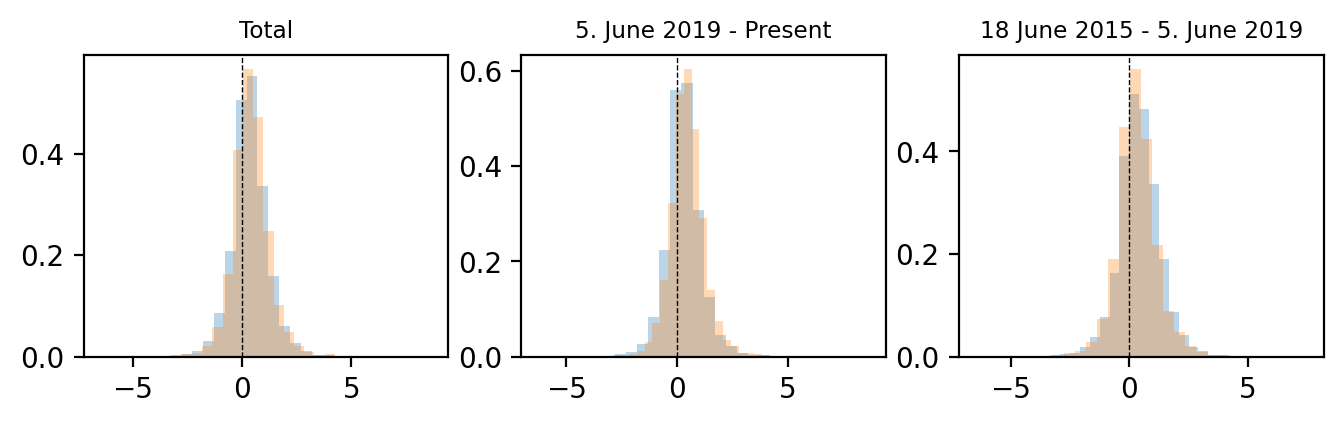

In [716]:
# Create two dataframes
df_2017_valg = df_main_done.loc[df_main_done['Date'] >= '2015-06-18'].reset_index(drop=True)
df_2017_valg = df_2017_valg.loc[df_2017_valg['Date'] <= '2019-06-05'].reset_index(drop=True)
df_2019_valg = df_main_done.loc[df_main_done['Date'] >= '2019-06-05'].reset_index(drop=True)

df_blue = df_main_done[df_main_done['y']==1]
df_red  = df_main_done[df_main_done['y']==0]

df_blue_2017 = df_2017_valg[df_2017_valg['y']==1]
df_red_2017  = df_2017_valg[df_2017_valg['y']==0]

df_blue_2019 = df_2019_valg[df_2019_valg['y']==1]
df_red_2019  = df_2019_valg[df_2019_valg['y']==0]

xb = np.array(df_blue['Sentiment'].to_list())
xr = np.array(df_red['Sentiment'].to_list())
xb_2017 = np.array(df_blue_2017['Sentiment'].to_list())
xr_2017 = np.array(df_red_2017['Sentiment'].to_list())
xb_2019 = np.array(df_blue_2019['Sentiment'].to_list())
xr_2019 = np.array(df_red_2019['Sentiment'].to_list())


fig = plt.figure(figsize=(8, 2), dpi=200)
fig.subplots_adjust(hspace = 0.5)

ax_Total = fig.add_subplot(1,3,1)
ax_Total.hist(xb,bins=30, histtype= 'stepfilled',alpha= 0.3,density=True)
ax_Total.hist(xr,bins=30, histtype= 'stepfilled',alpha= 0.3,density=True)
ax_Total.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_Total.set_title('Total',size = 'small')

ax_2019 = fig.add_subplot(1,3,2)
ax_2019.hist(xb_2019,bins=30, histtype= 'stepfilled',alpha= 0.3,density=True)
ax_2019.hist(xr_2019,bins=30, histtype= 'stepfilled',alpha= 0.3,density=True)
ax_2019.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_2019.set_title('5. June 2019 - Present',size='small')

ax_2017 = fig.add_subplot(1,3,3)
ax_2017.hist(xb_2017,bins=30, histtype= 'stepfilled',alpha= 0.3,density=True)
ax_2017.hist(xr_2017,bins=30, histtype= 'stepfilled',alpha= 0.3,density=True)
ax_2017.axvline(0,color='black',linestyle='--',linewidth=0.5)
ax_2017.set_title('18 June 2015 - 5. June 2019',size='small')

DescribeResult(nobs=9601, minmax=(-5.0, 6.93), mean=0.46070201020727014, variance=0.7417545487970003, skewness=0.208781732060217, kurtosis=2.668404877510426)
DescribeResult(nobs=13385, minmax=(-4.67, 7.51), mean=0.3756555846096377, variance=0.6682744973285304, skewness=0.4294912907981968, kurtosis=3.4669174704716132)


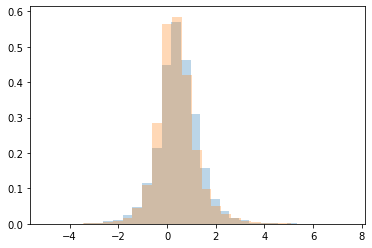

In [664]:
df_main_done = df_main_done.loc[df_main_done['Date'] <= '2019-06-05'].reset_index(drop=True)

df_main_done = df_main_done.loc[df_main_done['Date'] >= '2017-06-18'].reset_index(drop=True)

df_blue = df_main_done[df_main_done['y']==1]
df_red  = df_main_done[df_main_done['y']==0]

# df_blue['Sentiment'] = pd.to_numeric(df_blue['Sentiment'])
# df_blue['sen_group'] = pd.cut(df_blue['Sentiment'],10)

xb = df_blue['Sentiment'].to_list()
xr = df_red['Sentiment'].to_list()



xb_array = np.array(xb)
xr_array = np.array(xr)

print(stats.describe(xb_array))
print(stats.describe(xr_array))

plt.hist(xb_array,bins=30, histtype= 'stepfilled',alpha= 0.3,density=True)
plt.hist(xr_array,bins=30, histtype= 'stepfilled',alpha= 0.3,density=True)
plt.show()

In [654]:
words = vect.get_feature_names()
count = X_train.toarray().sum(axis=0).tolist()

df_word_count = pd.DataFrame([words,count]).T
df_word_count.sort_values(1,ascending=False).head(10)

,0,1
33,dkmedier,10247
170,sundpol,2531
89,kan,2001
69,god,1211
111,mener,1107
17,dag,1095
19,danmark,1092
196,vores,1012
175,tager,911
155,sige,873


In [466]:
dict = vect.vocabulary_
vocab_list = []
for keys in dict:
    value = dict[keys]
    vocab_list.append([keys,value])
df_vocab = pd.DataFrame(vocab_list,columns=['Word','Count'])
df_vocab


,Word,Count
0,del,28
1,plads,135
2,tid,177
3,både,14
4,før,61
...,...,...
195,samme,146
196,stærkt,166
197,nogen,126
198,fordi,52


In [452]:
### RESULTS on Final text###
# Info : Main
# 1. feature = 500, max_iter = 1000, solver = saga, penalty = l1
# 2. Result = 58.23 % 

# Info : New dates: from 2017 
# 1. feature = 500, max_iter = 1000, solver = saga, penalty = l1
# 2. Result = 58.03 % 
